# Handwritten Digit Recognition (MNIST)
## Using 5 layer Convolutional Neural Network 
### Activation function: RELU  
### Learning rate: dynamic 
### Including Dropouts for each RELU layer
### Batch Normalization

In [1]:
# including helper file to use some handy functions
import os
helper_file = os.getcwd() + '\\helpers.ipynb'
%run $helper_file

# importing needed libraries
import numpy as np
import tensorflow as tf
import math

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, reshape=False, validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
# parameters
BATCH_SIZE = 100
ITERATION_COUNT = 10000
ACCURACY_CHECK = 100

In [4]:
def train(mnist_data, batch_size, iteration_count, accuracy_check):
    
    IMAGE_WIDTH  = 28 # input image width
    IMAGE_HEIGHT = 28 # input image height
    C0 = 1            # input channel count
    C1 = 24 # convolutional network channel 1 count 
    C2 = 48 # convolutional network channel 2 count
    C3 = 64  # convolutional network channel 3 count
    C4 = 200  # fulley connected layer size
    C5 = 10  # output count (digit count 0 to 9)
    
    # input image placeholder: 28x28 grayscale
    # the first dimension is each image's index
    X = tf.placeholder(tf.float32, shape=[None, IMAGE_WIDTH, IMAGE_HEIGHT, C0])
    
    # placeholder for correct answers
    Y_ = tf.placeholder(tf.float32, [None, C5])
    
    # paceholder for learing_rate variable
    lr = tf.placeholder(tf.float32)
    
    # test flag for batch norm
    tst = tf.placeholder(tf.bool)
    iter = tf.placeholder(tf.int32)
    
    # dropout probability
    pkeep = tf.placeholder(tf.float32)
    pkeep_conv = tf.placeholder(tf.float32)
    
    def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
        exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
        bnepsilon = 1e-5
        if convolutional:
            mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
        else:
            mean, variance = tf.nn.moments(Ylogits, [0])
        update_moving_everages = exp_moving_avg.apply([mean, variance])
        m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
        v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
        Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
        return Ybn, update_moving_everages

    def no_batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
        return Ylogits, tf.no_op()
    
    def compatible_convolutional_noise_shape(Y):
        noiseshape = tf.shape(Y)
        noiseshape = noiseshape * tf.constant([1,0,0,1]) + tf.constant([0,1,1,0])
        return noiseshape
        
    # weights
    W1 = tf.Variable(tf.truncated_normal([6, 6, C0, C1], stddev = 0.1)) 
    W2 = tf.Variable(tf.truncated_normal([5, 5, C1, C2], stddev = 0.1))
    W3 = tf.Variable(tf.truncated_normal([4, 4, C2, C3], stddev = 0.1))
    W4 = tf.Variable(tf.truncated_normal([7 * 7 * C3, C4], stddev = 0.1))
    W5 = tf.Variable(tf.truncated_normal([C4, C5], stddev = 0.1))
    
    # biases
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [C1]))
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [C2]))
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [C3]))
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [C4]))
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [C5]))

    # Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
    pkeep = tf.placeholder(tf.float32)
    
    # model
    stride = 1  # output is 28x28
    Y1l = tf.nn.conv2d(X, W1, strides = [1, stride, stride, 1], padding = 'SAME')
    Y1bn, update_ema1 = batchnorm(Y1l, tst, iter, B1, convolutional = True)
    Y1r = tf.nn.relu(Y1bn)
    Y1 = tf.nn.dropout(Y1r, pkeep_conv, compatible_convolutional_noise_shape(Y1r))

    stride = 2  # output is 14x14
    Y2l = tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME')
    Y2bn, update_ema2 = batchnorm(Y2l, tst, iter, B2, convolutional=True)
    Y2r = tf.nn.relu(Y2bn)
    Y2 = tf.nn.dropout(Y2r, pkeep_conv, compatible_convolutional_noise_shape(Y2r))

    stride = 2  # output is 7x7
    Y3l = tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME')
    Y3bn, update_ema3 = batchnorm(Y3l, tst, iter, B3, convolutional=True)
    Y3r = tf.nn.relu(Y3bn)
    Y3 = tf.nn.dropout(Y3r, pkeep_conv, compatible_convolutional_noise_shape(Y3r))

    # reshape the output from the third convolution for the fully connected layer
    YY = tf.reshape(Y3, shape=[-1, 7 * 7 * C3])
    
    Y4l = tf.matmul(YY, W4)
    Y4bn, update_ema4 = batchnorm(Y4l, tst, iter, B4)
    Y4r = tf.nn.relu(Y4bn)
    Y4 = tf.nn.dropout(Y4r, pkeep)
    Ylogits = tf.matmul(Y4, W5) + B5
    Y = tf.nn.softmax(Ylogits)
    
    update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4)

    # cross-entropy loss function (= -sum(Y_i * log(Yi)) ), normalised for batches of 100  images
    # TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
    # problems with log(0) which is NaN
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = Ylogits, labels = Y_)
    cross_entropy = tf.reduce_mean(cross_entropy) * 100
    
    # accuracy of the trained model, between 0 (worst) and 1 (best)
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # training step, the learning rate is a placeholder
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

    # initialisation
    init = tf.global_variables_initializer()

    # start computation
    sess = tf.Session()
    sess.run(init)
    
    # preparing return values
    counter = 0 
    upper_bound = int(iteration_count / accuracy_check)
    iterations = np.arange(0, upper_bound)
    train_accuracy = np.zeros(upper_bound)
    train_loss = np.zeros(upper_bound)
    test_accuracy = np.zeros(upper_bound)
    test_loss = np.zeros(upper_bound)
    learning_rates = np.zeros(1)
    
    for i in range(iteration_count):
        
        # learning rate decay
        max_learning_rate = 0.002
        min_learning_rate = 0.0001
        decay_speed = 1600
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
        
        # load batch of images and correct answers
        batch_X , batch_Y = mnist_data.train.next_batch(batch_size)
        
        # train
        # the backpropagation training step
        sess.run(train_step, {X: batch_X, Y_: batch_Y, lr: learning_rate, tst: False, pkeep: 0.75, pkeep_conv: 1.0})
        sess.run(update_ema, {X: batch_X, Y_: batch_Y, tst: False, iter: i, pkeep: 1.0, pkeep_conv: 1.0})
        
        if i % accuracy_check == 0:

            a, c = sess.run([accuracy, cross_entropy], {X: batch_X, Y_: batch_Y, tst: False, pkeep: 1.0, pkeep_conv: 1.0})
            train_accuracy[counter] = a
            train_loss[counter] = c
            print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(learning_rate) + ")")
        
        
            pred, a, c = sess.run([Y, accuracy, cross_entropy], {X: mnist.test.images, Y_: mnist.test.labels, tst: True, pkeep: 1.0, pkeep_conv: 1.0})
            test_accuracy[counter] = a
            test_loss[counter] = c
            predictions = tf.argmax(pred,1).eval(session=sess)
            print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
            
            counter += 1
            
    learning_rates[0] = learning_rate
    #acc = accuracy.eval(session = sess, feed_dict = {X: mnist_data.test.images, Y_: mnist_data.test.labels, pkeep: 1.0})
    #print('Learning Rate: {}, Accuracy: {}'.format(learning_rate, acc))
    sess.close()
    
    return iterations, train_accuracy, train_loss, test_accuracy, test_loss, predictions, learning_rates;

In [5]:
train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []

%time acc_check, temp_train_acc, temp_train_loss, temp_test_acc, temp_test_loss, predictions, learning_rates = train(mnist, BATCH_SIZE, ITERATION_COUNT, ACCURACY_CHECK)

train_accuracy.append(temp_train_acc)
train_loss.append(temp_train_loss)
test_accuracy.append(temp_test_acc)
test_loss.append(temp_test_loss)

0: accuracy:0.83 loss: 90.554 (lr:0.002)
0: ********* epoch 1 ********* test accuracy:0.4512 test loss: 166.987
100: accuracy:0.98 loss: 11.2143 (lr:0.001884884819345604)
100: ********* epoch 1 ********* test accuracy:0.9565 test loss: 15.3555
200: accuracy:0.97 loss: 7.33671 (lr:0.0017767441149107313)
200: ********* epoch 1 ********* test accuracy:0.9747 test loss: 8.22071
300: accuracy:0.97 loss: 7.19764 (lr:0.0016751553245427607)
300: ********* epoch 1 ********* test accuracy:0.981 test loss: 6.03861
400: accuracy:1.0 loss: 2.78675 (lr:0.0015797214878356693)
400: ********* epoch 1 ********* test accuracy:0.9821 test loss: 6.0675
500: accuracy:1.0 loss: 2.18262 (lr:0.0014900696949986195)
500: ********* epoch 1 ********* test accuracy:0.9858 test loss: 4.46716
600: accuracy:0.98 loss: 2.86206 (lr:0.0014058496297028472)
600: ********* epoch 2 ********* test accuracy:0.9865 test loss: 4.00235
700: accuracy:1.0 loss: 1.07322 (lr:0.001326732200212995)
700: ********* epoch 2 ********* test

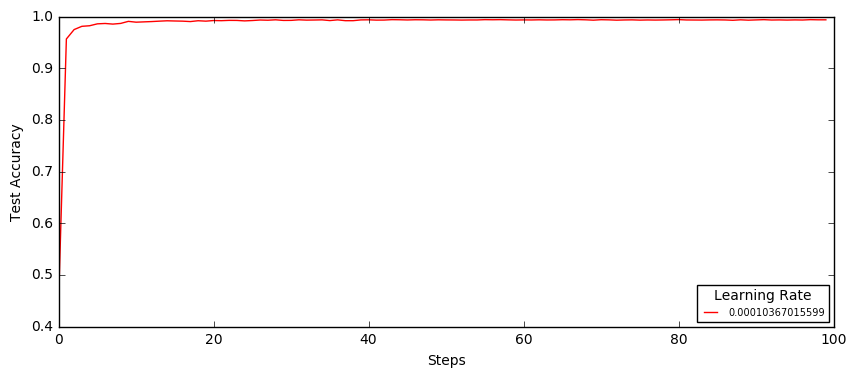

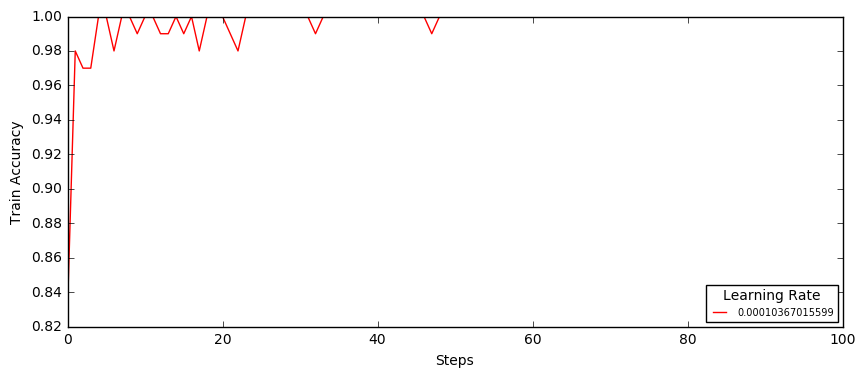

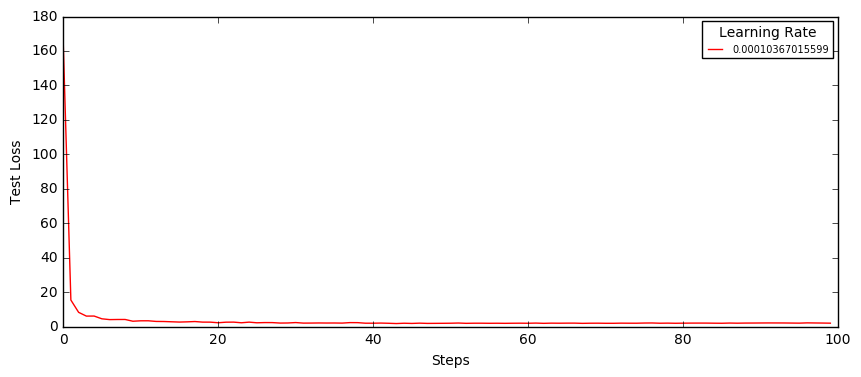

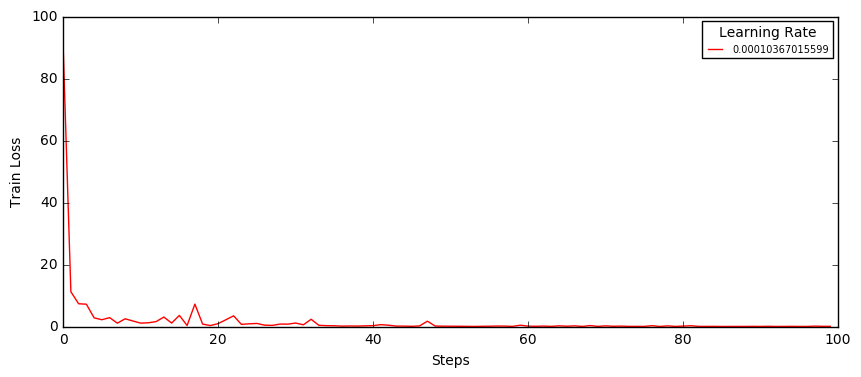

In [6]:
plot_performance(acc_check, learning_rates, train_accuracy, train_loss, test_accuracy, test_loss)

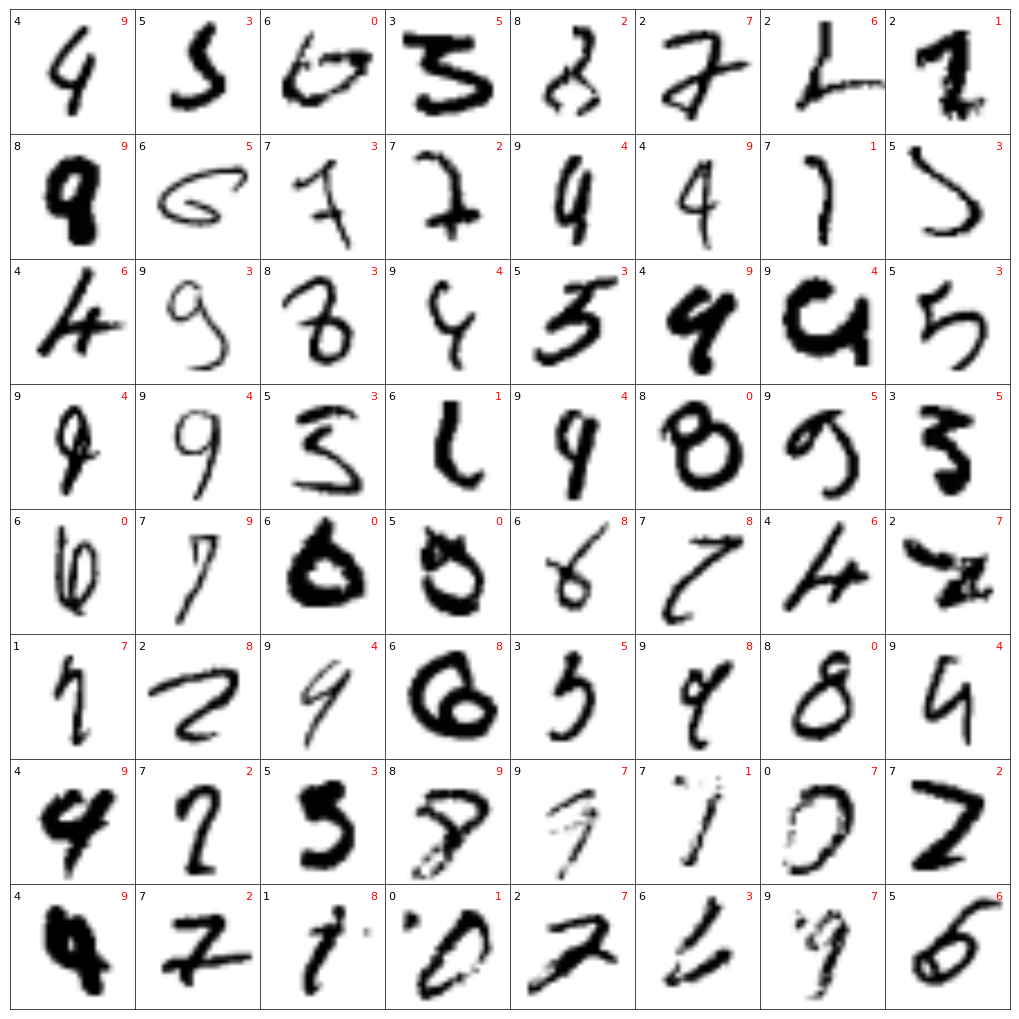

In [9]:
labels = np.argmax(mnist.test.labels, 1)
incorects = np.not_equal(labels, predictions)
plot_batch_images(mnist.test.images[incorects], labels[incorects], predictions[incorects], 64)